In [1]:
'''
Get resources
'''
import sys
sys.path.insert(1,"/Users/admin/Desktop/jasmine/lakes21_parquet/Eco_KGML_workshop")  #change path to local file

import os
if os.path.exists("/Users/admin/Desktop/jasmine/lakes21_parquet/Eco_KGML_workshop"):  
 print("Directory already exists.")
else:
 os.system("git clone https://github.com/sepidehfat/Eco_KGML_workshop.git")
 print("Repository cloned.")

Directory already exists.


In [2]:
'''
Import necessary modules
'''
import random
import pandas as pd
import numpy as np
from tqdm import trange
import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from utils import  run_all, Utils
from encoder_decoder import seq2seq

import warnings
warnings.filterwarnings('ignore')
import copy

In [3]:
'''
Set up environment - Running on GPU if available
'''
if torch.cuda.is_available():
    device=torch.device("cuda")
    print('Computational device:GPU')

else:
    device=torch.device('cpu')
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under Runtime -> "
        "Change runtime type. select GPU.")

In [4]:
'''
Set up environment - Handles variabilty and remain reproducible by controlling sources of randomness through setting seed values
'''
seed = 2024

np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
'''
Define some hyperparameters required for learning
'''
#Type of the model
model_type='LSTM'

#Output size of our encoder_decoder model(Number of target variable)
output_size=1

#Number of layers in our deep learning model
num_layer=1

#Hidden cell size
hidden_feature_size=64

#Dropout is a form of regularization
dropout = 0.05

#Whether we want to shuffle the batches while generating the training batches
batch_shuffle = True

#Frequency of evaluation --> if iteration_num % eval_freq ==0 --> then perform evaluation
eval_freq = 1 

'''
Learning rate scheduler parameters
'''
max_lr=5e-4
div_factor=100
pct_start=0.05
anneal_strategy='cos'
final_div_factor=10000.0

'''
Parameters for early stopping
'''
early_stop = True
#If there is no imrovement for a 'thres' number of epochs, stop the training process
thres=5
#Quantifying the improvement. If the loss is greater than min_val_loss_so_far + delta for thres number of iterations, stop the training
delta=0.5
#Specifying the percentage of times we want to enforce teacher forcing
teacher_forcing_ratio = 0.0
training_prediction = 'recursive'

In [6]:
'''
Read 13-lakes file
'''
file_name='combined_13_lakes.csv'
lakes_df=pd.read_csv(file_name)
lakes_df

,datetime,lake_id,date,time,do,temp,tp,tn,do_lf,secchi
0,2017-01-24 09:00:00,CB,2017-01-24,09:00:00,1.46000,1.080000,20.236486,752.523649,9.670270,0.782432
1,2017-01-24 10:00:00,CB,2017-01-24,10:00:00,1.46000,1.110000,20.243243,752.657658,9.668468,0.782883
2,2017-01-24 11:00:00,CB,2017-01-24,11:00:00,1.31000,1.090000,20.250000,752.791667,9.666667,0.783333
3,2017-01-24 12:00:00,CB,2017-01-24,12:00:00,0.69000,1.090000,20.256757,752.925676,9.664865,0.783784
4,2017-01-24 13:00:00,CB,2017-01-24,13:00:00,0.59000,1.090000,20.263514,753.059685,9.663063,0.784234
...,...,...,...,...,...,...,...,...,...,...
130891,2021-12-31 19:00:00,BVR,2021-12-31,19:00:00,12.67576,7.816064,19.998139,284.517677,11.826002,1.750000
130892,2021-12-31 20:00:00,BVR,2021-12-31,20:00:00,12.80312,7.901361,19.996509,284.533160,11.827020,1.750000
130893,2021-12-31 21:00:00,BVR,2021-12-31,21:00:00,12.80625,8.003748,19.994880,284.548644,11.828039,1.750000
130894,2021-12-31 22:00:00,BVR,2021-12-31,22:00:00,12.70525,8.142634,19.993250,284.564127,11.829057,1.750000


In [7]:
'''
Filter specific columns from lakes_df for training
'''
lakes_df_training=lakes_df.loc[:,["date","time","do","temp","tp","tn","do_lf","secchi"]]

In [8]:
'''
Define columns(features, date, target) for learning
'''
feature_cols=['temp','tp','tn','do_lf','secchi']
date_col=['date','time']
target_col=['do']

In [9]:
'''
Create a utility object
'''
utils = Utils(num_features=len(feature_cols), inp_cols=feature_cols, target_cols=target_col, date_col=date_col, num_out_features=output_size, device=device)

In [10]:
'''
Split train/test data
'''
split_ratio=0.6
df_train,df_test=utils.train_test_split(lakes_df_training,split_ratio=split_ratio)
df_train

,date,time,do,temp,tp,tn,do_lf,secchi
0,2017-01-24,09:00:00,1.46,1.080000,20.236486,752.523649,9.670270,0.782432
1,2017-01-24,10:00:00,1.46,1.110000,20.243243,752.657658,9.668468,0.782883
2,2017-01-24,11:00:00,1.31,1.090000,20.250000,752.791667,9.666667,0.783333
3,2017-01-24,12:00:00,0.69,1.090000,20.256757,752.925676,9.664865,0.783784
4,2017-01-24,13:00:00,0.59,1.090000,20.263514,753.059685,9.663063,0.784234
...,...,...,...,...,...,...,...,...
78532,2018-11-28,21:00:00,11.93,5.431421,6.869048,174.397619,10.790249,1.985966
78533,2018-11-28,22:00:00,11.95,5.374566,6.869345,174.376488,10.791929,1.986056
78534,2018-11-28,23:00:00,11.94,5.316827,6.869643,174.355357,10.793610,1.986145
78535,2018-11-29,00:00:00,11.95,5.282922,6.869940,174.334226,10.795290,1.986234


In [11]:
'''
Normalize the data
'''
df_train=utils.normalize(df_train)
df_test=utils.normalize(df_test,use_stat=True)
df_test

,date,time,do,temp,tp,tn,do_lf,secchi
0,2018-11-29,02:00:00,2.940785,-0.682086,-1.045193,-1.974670,1.734377,1.305336
1,2018-11-29,03:00:00,2.940785,-0.680298,-1.045174,-1.974748,1.734965,1.305470
2,2018-11-29,04:00:00,2.947441,-0.668061,-1.045154,-1.974825,1.735554,1.305603
3,2018-11-29,05:00:00,2.960754,-0.654965,-1.045134,-1.974902,1.736143,1.305737
4,2018-11-29,06:00:00,2.980724,-0.632766,-1.045114,-1.974980,1.736731,1.305871
...,...,...,...,...,...,...,...,...
52354,2021-12-31,19:00:00,3.172355,-0.385375,-0.165074,-1.571125,2.094285,0.951150
52355,2021-12-31,20:00:00,3.214744,-0.375800,-0.165183,-1.571068,2.094642,0.951150
52356,2021-12-31,21:00:00,3.215786,-0.364307,-0.165292,-1.571012,2.094999,0.951150
52357,2021-12-31,22:00:00,3.182170,-0.348717,-0.165402,-1.570955,2.095356,0.951150


In [12]:
'''
Generating data samples
'''
#Lookback window
input_window=14

#Horizon window
output_window=7

#Define the number of stride the sliding window need to take  while creating each sample(lookback window + horizon window= 1 sample)
stride=1

#Create samples: 1 sample = lookback window + horizon window
x_train,y_train=utils.windowed_dataset(df_train,input_window,output_window,stride)
x_test,y_test=utils.windowed_dataset(df_test,input_window,output_window,stride)

In [13]:
'''
Modeling - Define hyperparameters for model training
'''
#Batch size during training
batch_size=32

#Number of epochs(1 epoch = 1 pass of the complete training data through the model)
epochs=100

#Learning rate specifies the rate where we want to update the model parameters after every training pass
learning_rate=0.0001

#Specify the amount of L2 regularization to be applied
weight_decay=0.05


In [14]:
'''
Define config file
'''
config={
    "batch_size":batch_size,
    "epochs":epochs,
    "learning_rate":learning_rate,
    "eval_freq":eval_freq,
    "batch_shuffle":batch_shuffle,
    "dropout":dropout,
    "num_layers":num_layer,
    "hidden_feature_size":hidden_feature_size,
    "model_type":model_type,
    "teacher_forcing_ratio":teacher_forcing_ratio,
    "max_lr":max_lr,
    "div_factor":div_factor,
    "pct_start":pct_start,
    "anneal_strategy":anneal_strategy,
    "final_div_factor":final_div_factor,
    "dataset":file_name,
    "split_ratio":split_ratio,
    "input_window":input_window,
    "output_window":output_window,
    "early_stop_thres":thres,
    "early_stop_delta":delta,
    "early_stop":early_stop,
    "weight_decay":weight_decay
}

In [15]:
'''
Create the seq2seq model
'''
model=seq2seq(input_size=x_train.shape[2],
              hidden_size=hidden_feature_size,
              output_size=output_size,
              model_type=model_type,
              num_layers=num_layer,
              utils=utils,
              dropout=dropout,
              device=device
              )

In [16]:
'''
Train the model
'''
loss,test_rmse,train_rmse=model.train_model(x_train,y_train,x_test,y_test,
                                            target_len=output_window,
                                            config=config,
                                            training_prediction=training_prediction)

 25%|██▌       | 25/100 [15:40<47:00, 37.60s/it, loss=0.283, test_rmse=5.83, train_rmse=1.61]

Early stopping


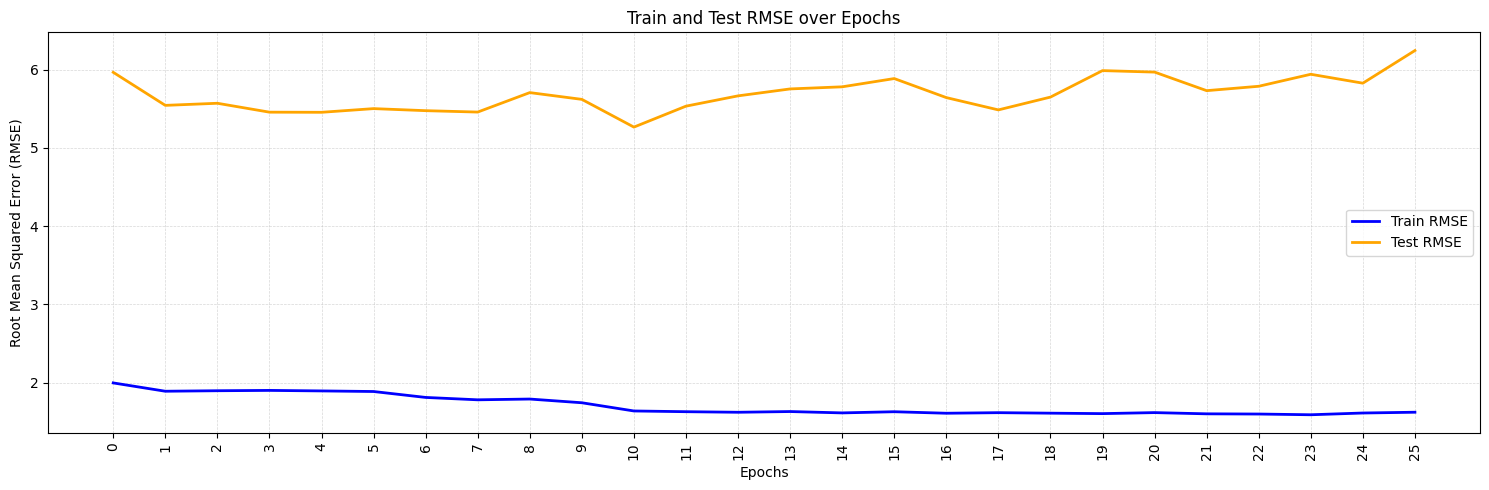

In [17]:
'''
Plot train-test Root Mean Squared Error(RMSE)
'''
utils.plot_RMSE_epochs(test_rmse,train_rmse)

In [18]:
'''
Fine-tune the pre-trained model by lowering number of epoch and maxium learning rate
'''
finetune_config=copy.deepcopy(config)
finetune_config['epochs']=60
finetune_config['max_lr']=1e-4


'''
Define a seq2seq model 
'''
finetune_model=seq2seq(input_size=x_train.shape[2],
                       hidden_size=hidden_feature_size,
                       output_size=output_size,
                       model_type=model_type,
                       num_layers=num_layer,
                       utils=utils,
                       dropout=dropout,
                       device=device)

'''
Load pre-trained model's parameters to update finetune_model's parameters
'''
finetune_model.load_state_dict(model.state_dict())  


<All keys matched successfully>

In [19]:
'''
Read the file with Lake Mendota's data
'''
file_name='lake_me_year.csv'
me_df=pd.read_csv(file_name)
me_df=me_df[(me_df['year']==2019) | (me_df['year']==2020)]

'''
An Adjustment on datetimes that include time at 12:00 am
'''
def add_missing_time(datetime):
    if len(datetime)==10:
        return datetime+ ' 00:00:00'
    return datetime

me_df['datetime']=me_df['datetime'].apply(add_missing_time)
me_df

,datetime,lake_id,date,time,do,temp,tp,tn,do_lf,secchi,year
9060,2019-04-16 14:00:00,ME,2019-04-16,14:00:00,15.21,6.09,67.231876,1950.351190,15.166369,1.840774,2019
9061,2019-04-16 15:00:00,ME,2019-04-16,15:00:00,15.72,5.98,67.002815,1950.452381,15.170238,1.844048,2019
9062,2019-04-16 16:00:00,ME,2019-04-16,16:00:00,15.80,7.19,66.773754,1950.553571,15.174107,1.847321,2019
9063,2019-04-16 17:00:00,ME,2019-04-16,17:00:00,16.02,6.71,66.544693,1950.654762,15.177976,1.850595,2019
9064,2019-04-16 18:00:00,ME,2019-04-16,18:00:00,16.19,5.82,66.315632,1950.755952,15.181845,1.853869,2019
...,...,...,...,...,...,...,...,...,...,...,...
18542,2020-11-21 04:00:00,ME,2020-11-21,04:00:00,10.87,7.62,0.105959,1424.391892,12.297748,5.296847,2020
18543,2020-11-21 05:00:00,ME,2020-11-21,05:00:00,10.89,7.59,0.105980,1424.695946,12.298874,5.298423,2020
18544,2020-11-21 06:00:00,ME,2020-11-21,06:00:00,10.84,7.58,0.106000,1425.000000,12.300000,5.300000,2020
18545,2020-11-21 07:00:00,ME,2020-11-21,07:00:00,10.88,7.57,0.106020,1425.304054,12.301126,5.301577,2020


In [20]:
'''
Filter specific columns from me_df for training
'''
me_df_training=me_df.loc[:,["datetime","date","time","do","temp","tp","tn","do_lf","secchi"]]
me_df_training.dtypes

datetime     object
date         object
time         object
do          float64
temp        float64
tp          float64
tn          float64
do_lf       float64
secchi      float64
dtype: object

In [21]:
'''
Split train/test data
'''
split_ratio=0.6
df_train,df_test=utils.train_test_split(me_df_training,split_ratio=split_ratio)

'''
Normalize the data
'''
df_train=utils.normalize(df_train)
df_test=utils.normalize(df_test,use_stat=True)

In [22]:
'''
Generating Lake Mendota's data samples
'''
input_window=14
output_window=7
stride=1
x_train,y_train=utils.windowed_dataset(df_train,input_window,output_window,stride)
x_test,y_test=utils.windowed_dataset(df_test,input_window,output_window,stride)

In [23]:
'''
Fine-tune the model
'''
finetune_loss,finetune_test_rmse,finetune_train_rmse=finetune_model.train_model(x_train,y_train,x_test,y_test,
                                            target_len=output_window,
                                            config=finetune_config,
                                            training_prediction=training_prediction)

 23%|██▎       | 14/60 [00:38<02:05,  2.72s/it, loss=0.122, test_rmse=2.21, train_rmse=1]   

Early stopping


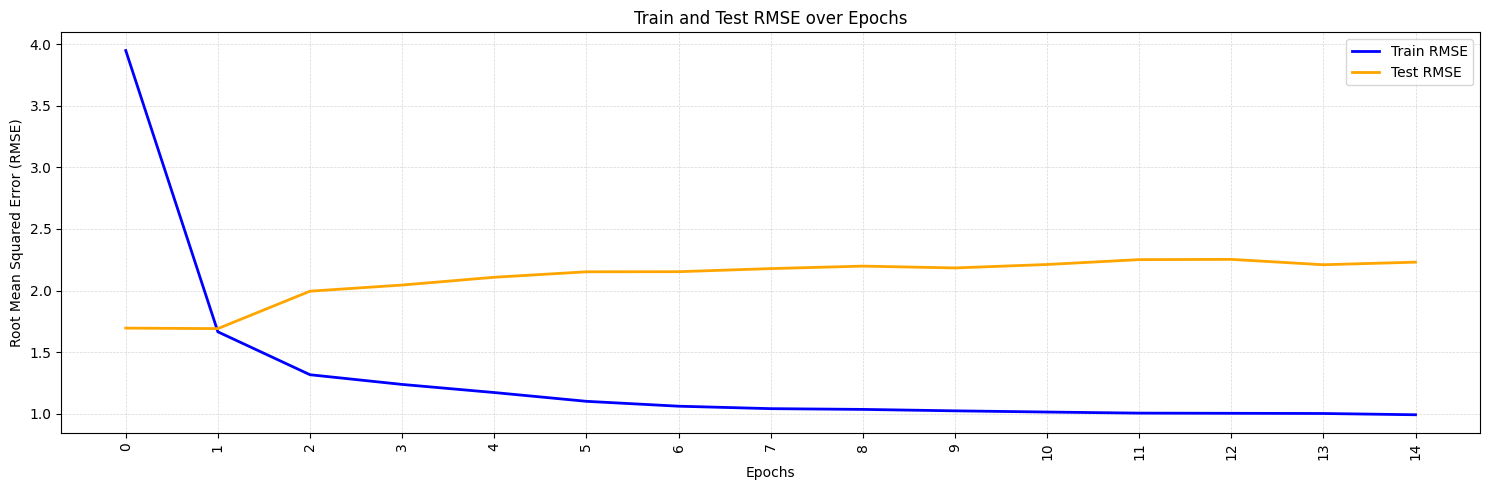

In [24]:
'''
Plot train-test RMSE
'''
utils.plot_RMSE_epochs(finetune_test_rmse,finetune_train_rmse)

In [25]:
'''
Evaluation - Perform Evaluation
'''
train_eval_metrics=model.evaluate_batch(x_train.to(device),y_train.to(device))
test_eval_metrics=model.evaluate_batch(x_test.to(device),y_test.to(device))

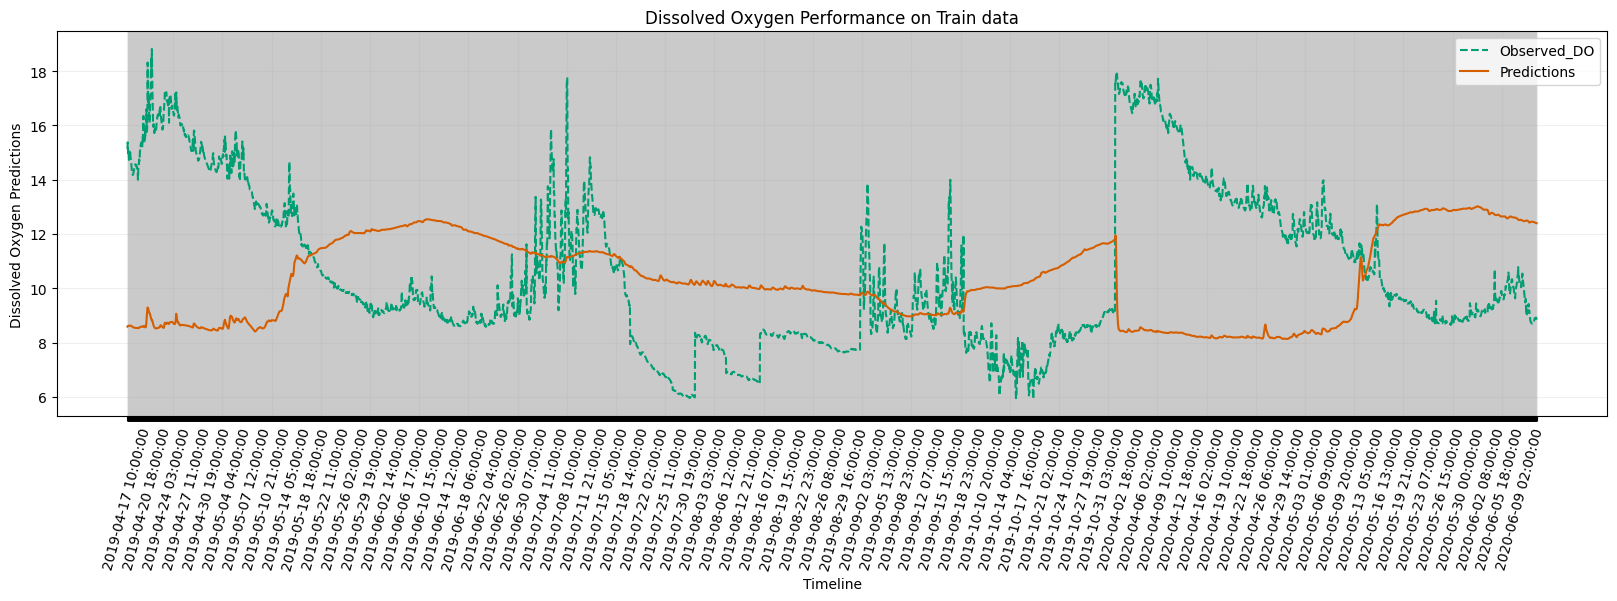

,T+str(t)
2019-04-17 10:00:00,8.586114
2019-04-17 11:00:00,8.600042
2019-04-17 12:00:00,8.614839
2019-04-17 13:00:00,8.621623
2019-04-17 14:00:00,8.623038
...,...
2020-06-11 17:00:00,12.411501
2020-06-11 18:00:00,12.407908
2020-06-11 19:00:00,12.404455
2020-06-11 20:00:00,12.401181


In [26]:
'''
Visualization - Generate the plots on train data
'''
horizon_range=[1] #Specify the list of T+n prediction to plot
plot_df_train=utils.plot_predictions(df_train,train_eval_metrics,horizon_range,split='Train')
# this will plot T+1 predictions and Ground Observed Dissolved Oxygen and create a dataset(Timeline as tag and T+1 predictions as a column) for plotting in R later
plot_df_train

In [27]:
'''
Convert the tag(Timeline) to a column and rename it
'''
plot_df_train=plot_df_train.reset_index()
plot_df_train.rename(columns={'index':'datetime'},inplace=True)

In [28]:
'''
Merge plot_df_train(the dataset with predictions) with actual observations
'''
merged_df_train=pd.merge(plot_df_train,me_df,on='datetime',how='left')
merged_df_train

,datetime,T+str(t),lake_id,date,time,do,temp,tp,tn,do_lf,secchi,year
0,2019-04-17 10:00:00,8.586114,ME,2019-04-17,10:00:00,15.15,4.67,62.650656,1952.375000,15.243750,1.906250,2019
1,2019-04-17 11:00:00,8.600042,ME,2019-04-17,11:00:00,15.38,4.77,62.421595,1952.476190,15.247619,1.909524,2019
2,2019-04-17 12:00:00,8.614839,ME,2019-04-17,12:00:00,15.08,4.67,62.192534,1952.577381,15.251488,1.912798,2019
3,2019-04-17 13:00:00,8.621623,ME,2019-04-17,13:00:00,14.98,4.59,61.963473,1952.678571,15.255357,1.916071,2019
4,2019-04-17 14:00:00,8.623038,ME,2019-04-17,14:00:00,15.08,4.63,61.734412,1952.779762,15.259226,1.919345,2019
...,...,...,...,...,...,...,...,...,...,...,...,...
5661,2020-06-11 17:00:00,12.411501,ME,2020-06-11,17:00:00,8.90,19.87,0.091933,1610.333333,10.004167,7.123333,2020
5662,2020-06-11 18:00:00,12.407908,ME,2020-06-11,18:00:00,8.92,19.88,0.091967,1610.166667,10.002083,7.111667,2020
5663,2020-06-11 19:00:00,12.404455,ME,2020-06-11,19:00:00,8.92,19.87,0.092000,1610.000000,10.000000,7.100000,2020
5664,2020-06-11 20:00:00,12.401181,ME,2020-06-11,20:00:00,8.89,19.83,0.091851,1607.152778,10.009028,7.085764,2020


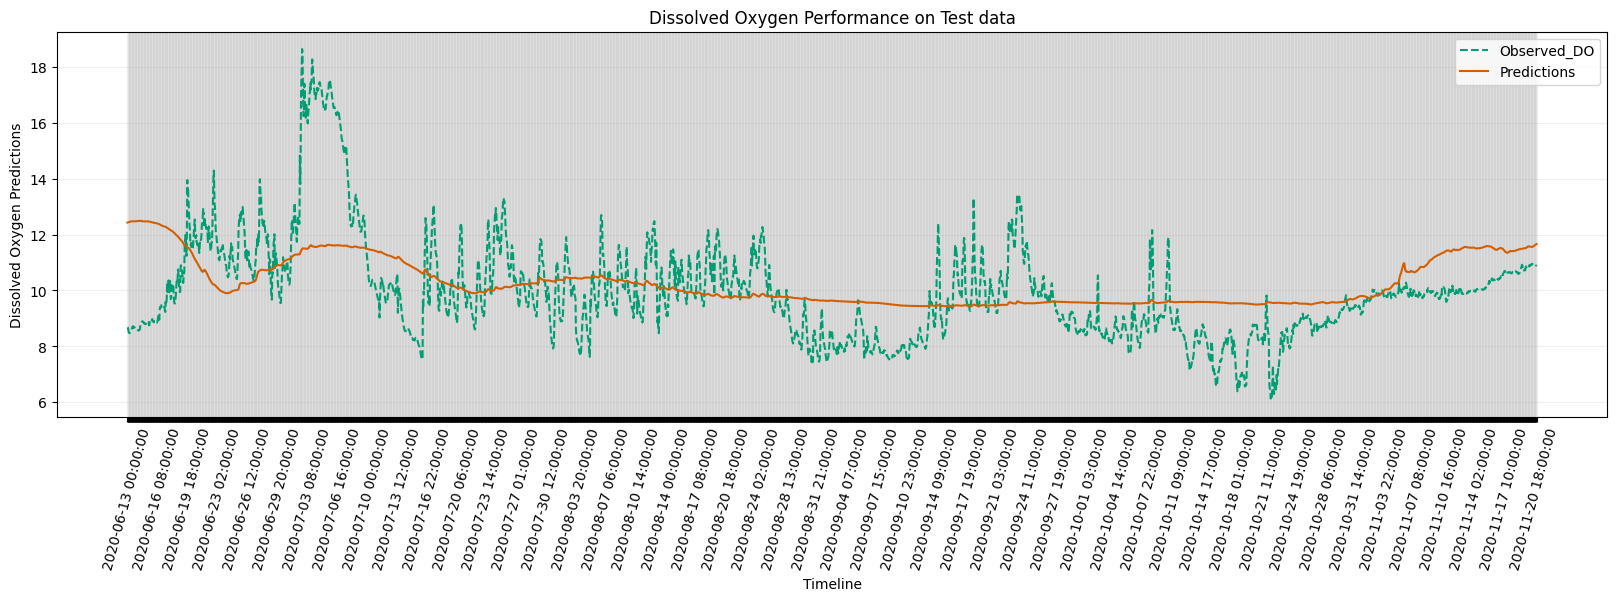

In [29]:
'''
Visualization - Generate the plots on test data
'''
horizon_range=[1]  #Specify the list of T+n predictions to plot
plot_df_test=utils.plot_predictions(df_test,test_eval_metrics,horizon_range,split='Test')
#this will plot T+1 predictions and Ground Observed Dissolved Oxygen and create a dataset(Timeline as tag and T+1 predictions as a column) for plotting in R later

In [30]:
'''
Convert the tag(Timeline) to a column and rename it
'''
plot_df_test=plot_df_test.reset_index()
plot_df_test.rename(columns={'index':'datetime'},inplace=True)

In [31]:
'''
Merge plot_df_test(the dataset with predictions) with actual observations
'''
merged_df_test=pd.merge(plot_df_test,me_df,on='datetime',how='left')
merged_df_test

,datetime,T+str(t),lake_id,date,time,do,temp,tp,tn,do_lf,secchi,year
0,2020-06-13 00:00:00,12.428785,ME,2020-06-13,00:00:00,8.68,20.13,0.087670,1527.430556,10.261806,6.687153,2020
1,2020-06-13 01:00:00,12.434667,ME,2020-06-13,01:00:00,8.67,20.05,0.087521,1524.583333,10.270833,6.672917,2020
2,2020-06-13 02:00:00,12.439862,ME,2020-06-13,02:00:00,8.61,19.86,0.087372,1521.736111,10.279861,6.658681,2020
3,2020-06-13 03:00:00,12.444468,ME,2020-06-13,03:00:00,8.53,19.72,0.087222,1518.888889,10.288889,6.644444,2020
4,2020-06-13 04:00:00,12.449200,ME,2020-06-13,04:00:00,8.48,19.59,0.087073,1516.041667,10.297917,6.630208,2020
...,...,...,...,...,...,...,...,...,...,...,...,...
3764,2020-11-20 22:00:00,11.623859,ME,2020-11-20,22:00:00,10.92,7.64,0.105838,1422.567568,12.290991,5.287387,2020
3765,2020-11-20 23:00:00,11.636349,ME,2020-11-20,23:00:00,10.93,7.62,0.105858,1422.871622,12.292117,5.288964,2020
3766,2020-11-21 00:00:00,11.647190,ME,2020-11-21,00:00:00,10.90,7.62,0.105878,1423.175676,12.293243,5.290541,2020
3767,2020-11-21 01:00:00,11.655248,ME,2020-11-21,01:00:00,10.89,7.62,0.105899,1423.479730,12.294369,5.292117,2020


In [32]:
'''
Save merged datasets as csv files for further analysis and plotting
'''
merged_df_train.to_csv('/Users/admin/Desktop/jasmine/ Outcomes/merged_df_train.csv',index=False)  #change to local file
merged_df_test.to_csv('/Users/admin/Desktop/jasmine/ Outcomes/merged_df_test.csv',index=False)